In [60]:
import geopandas as gpd 
import xarray as xr
import pandas as pd
import os
import numpy as np
import cfgrib
from cfgrib import cfmessage
from pathlib import Path
import eccodes
import matplotlib.pyplot as plt
import rioxarray
from shapely.geometry import shape
from shapely.ops import unary_union
import json, ast


Ruta de archivo S5P

In [2]:
s5p_path = "../Data/raw/s5p/SO2_NO2_O3_Diario_Comunas_Region_de_Los_Rios.csv"
s5p = pd.read_csv(s5p_path)
s5p.head(5)

,system:index,Comuna,NO2_column_number_density,O3_column_number_density,Provincia,Region,SO2_column_number_density,cir_sena,cod_comuna,codregion,date,dis_elec,objectid,shape_leng,st_area_sh,st_length_,.geo
0,0_0000000000000000001e,La Unión,0.000072,0.133772,Ranco,Región de Los Ríos,0.000169,12,14201,14,2024-01-01,24,140,364280.015951,3.656689e+09,474203.726792,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.7..."
1,0_0000000000000000001f,Los Lagos,0.000072,0.133527,Valdivia,Región de Los Ríos,0.000547,12,14104,14,2024-01-01,24,143,316586.233799,3.042426e+09,412407.032880,"{""type"":""Polygon"",""coordinates"":[[[-72.9818706..."
2,0_00000000000000000020,Máfil,0.000070,0.134704,Valdivia,Región de Los Ríos,0.000409,12,14105,14,2024-01-01,24,144,181074.022363,9.787385e+08,235205.534329,"{""type"":""Polygon"",""coordinates"":[[[-73.0993812..."
3,0_00000000000000000021,Paillaco,0.000075,0.133430,Ranco,Región de Los Ríos,0.000024,12,14107,14,2024-01-01,24,146,209143.467414,1.540642e+09,273186.467923,"{""type"":""Polygon"",""coordinates"":[[[-73.1733890..."
4,0_00000000000000000085,Lanco,0.000076,0.135013,Valdivia,Región de Los Ríos,0.000908,12,14103,14,2024-01-01,24,142,152128.428573,8.938992e+08,196801.580866,"{""type"":""Polygon"",""coordinates"":[[[-72.8485345..."


Buscamos las variables que tiene el archivo ERA5

In [3]:
file_path = "../Data/raw/era5/data.grib"
short_names = set()

with open(file_path, "rb") as f:
    while True:
        try:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break
            short_name = eccodes.codes_get(gid, "shortName")
            short_names.add(short_name)
            eccodes.codes_release(gid)
        except Exception as e:
            break

print("Variables encontradas:", short_names)

Variables encontradas: {'10u', 'tp', '10v', '2d', '2t'}


Busco y separo cada parte del archivo en su variable para trabajarlas luego

In [4]:
era5_path = "../Data/raw/era5/data.grib"
output_dir = Path("../Data/processed/")
output_dir.mkdir(parents=True, exist_ok=True)

variables = ["2t", "2d", "tp", "10u", "10v"]

for var in variables:
    try:
        print(f"Abriendo {var}...")
        ds = xr.open_dataset(
            era5_path,
            engine="cfgrib",
            backend_kwargs={'filter_by_keys': {'shortName': var}}
        )
        ds.to_netcdf(output_dir / f"{var}.nc")
        print(f"✅ Guardado en {output_dir / f'{var}.nc'}")
    except Exception as e:
        print(f"⚠️ Error con {var}: {e}")

Abriendo 2t...
✅ Guardado en ..\Data\processed\2t.nc
Abriendo 2d...
✅ Guardado en ..\Data\processed\2d.nc
Abriendo tp...
✅ Guardado en ..\Data\processed\tp.nc
Abriendo 10u...
✅ Guardado en ..\Data\processed\10u.nc
Abriendo 10v...
✅ Guardado en ..\Data\processed\10v.nc


In [5]:
PROCESSED = "../Data/processed"

# util: abrir la 1ª variable del .nc como DataArray
def open_first_var(path_nc):
    ds = xr.open_dataset(path_nc)
    var = list(ds.data_vars)[0]
    return ds[var]

t2m_k = open_first_var(f"{PROCESSED}/2t.nc")
d2m_k = open_first_var(f"{PROCESSED}/2d.nc")

T  = t2m_k - 273.15
Td = d2m_k - 273.15

rh = 100.0 * np.exp((17.625*Td/(243.04 + Td)) - (17.625*T/(243.04 + T)))
rh = rh.clip(min=0, max=100).rename("rh_pct")

try:
    rh_daily = rh.resample(time="1D").mean().rename("rh_pct")
except Exception:
    rh_daily = rh

rh.to_netcdf(f"{PROCESSED}/rh_pct_hourly.nc")           # si tu serie es horaria
rh_daily.to_netcdf(f"{PROCESSED}/rh_pct_daily.nc")

rh_daily.to_dataframe().reset_index().to_parquet(f"{PROCESSED}/rh_pct_daily.parquet", index=False)

print("✅ RH diaria guardada en:", f"{PROCESSED}/rh_pct_daily.nc")


✅ RH diaria guardada en: ../Data/processed/rh_pct_daily.nc


In [6]:
nc_path = "../Data/processed/rh_pct_daily.nc"

# 1) Abrir NetCDF y tomar la variable (DataArray)
ds = xr.open_dataset(nc_path)
var_name = list(ds.data_vars)[0]
rh = ds[var_name]  # DataArray con dims (time, lat, lon) o (time) según tu resample

# 2) A DataFrame (quedará 'time' y 'rh_pct')
df = rh.to_dataframe().reset_index()

print("Columnas:", df.columns.tolist())
print("Filas:", len(df))
print("Primeras 5:")
display(df.head())
print("Últimas 5:")
display(df.tail())

# 3) Rango temporal y frecuencia
tmin, tmax = df["time"].min(), df["time"].max()
print("Rango temporal:", tmin, "→", tmax)

# Frecuencia (intento automático)
try:
    freq = pd.infer_freq(df["time"].sort_values())
    print("Frecuencia inferida:", freq)
except Exception:
    pass

# 4) Chequeo de días faltantes (si es diario)
ts = df["time"].sort_values()
exp = pd.date_range(ts.min().normalize(), ts.max().normalize(), freq="D")
missing = exp.difference(pd.to_datetime(ts).dt.normalize())
print("Días esperados:", len(exp), " | Días presentes:", ts.nunique(), " | Faltantes:", len(missing))
if len(missing) > 0:
    print("Ejemplos de días faltantes:", missing[:10])

Columnas: ['time', 'latitude', 'longitude', 'number', 'step', 'surface', 'rh_pct']
Filas: 29430
Primeras 5:


,time,latitude,longitude,number,step,surface,rh_pct
0,2024-01-01,-39.5,-73.90,0,0 days,0.0,91.140251
1,2024-01-01,-39.5,-73.65,0,0 days,0.0,91.772720
2,2024-01-01,-39.5,-73.40,0,0 days,0.0,91.685768
3,2024-01-01,-39.5,-73.15,0,0 days,0.0,93.392044
4,2024-01-01,-39.5,-72.90,0,0 days,0.0,94.087059


Últimas 5:


,time,latitude,longitude,number,step,surface,rh_pct
29425,2025-10-15,-40.5,-72.90,0,0 days,0.0,81.329422
29426,2025-10-15,-40.5,-72.65,0,0 days,0.0,85.126350
29427,2025-10-15,-40.5,-72.40,0,0 days,0.0,85.832916
29428,2025-10-15,-40.5,-72.15,0,0 days,0.0,88.328629
29429,2025-10-15,-40.5,-71.90,0,0 days,0.0,91.529915


Rango temporal: 2024-01-01 00:00:00 → 2025-10-15 00:00:00
Frecuencia inferida: None
Días esperados: 654  | Días presentes: 654  | Faltantes: 0


In [7]:
pq_path = "../Data/processed/rh_pct_daily.parquet"
try:
    df_pq = pd.read_parquet(pq_path)  # requiere pyarrow o fastparquet
    print("Parquet filas:", len(df_pq), " | columnas:", df_pq.columns.tolist())
    display(df_pq.head())
except Exception as e:
    print("No se pudo leer el Parquet:", e)

Parquet filas: 29430  | columnas: ['time', 'latitude', 'longitude', 'number', 'step', 'surface', 'rh_pct']


,time,latitude,longitude,number,step,surface,rh_pct
0,2024-01-01,-39.5,-73.90,0,0 days,0.0,91.140251
1,2024-01-01,-39.5,-73.65,0,0 days,0.0,91.772720
2,2024-01-01,-39.5,-73.40,0,0 days,0.0,91.685768
3,2024-01-01,-39.5,-73.15,0,0 days,0.0,93.392044
4,2024-01-01,-39.5,-72.90,0,0 days,0.0,94.087059


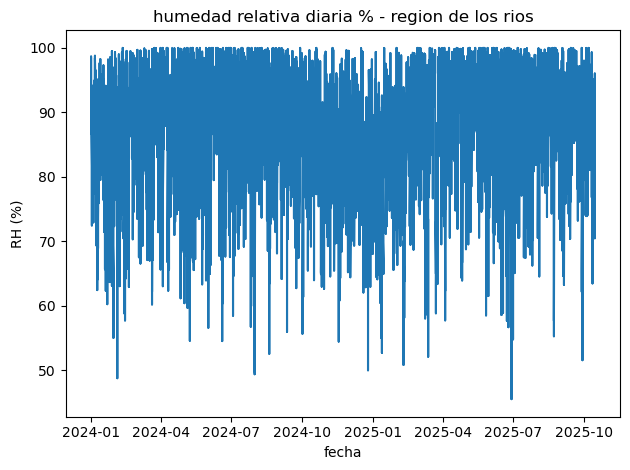

In [8]:
df_plot = df.sort_values("time")
plt.figure()
plt.plot(df_plot["time"], df_plot[var_name])
plt.title("humedad relativa diaria % - region de los rios")
plt.xlabel("fecha"); plt.ylabel("RH (%)")
plt.tight_layout()
plt.show()

Reproyectar a ERA5 a EPSG:32719 y resamplear a una rejilla común

In [9]:
rh = xr.open_dataset("../Data/processed/rh_pct_daily.nc") ["rh_pct"]
rh = rh.rio.write_crs("EPSG:4326", inplace=True)
rh_utm = rh.rio.reproject("EPSG:32719")
rh_utm_1km = rh_utm.rio.reproject(
    "EPSG:32719", resolution=1000
)
rh_utm_1km.to_netcdf("../Data/processed/rh_pct_utm1km.nc")
print("✅ Reproyección a EPSG:32719 completa.")

✅ Reproyección a EPSG:32719 completa.


Calculamos modulo de viento 

In [10]:
u10_path = "../Data/processed/10u.nc"
v10_path = "../Data/processed/10v.nc"

u10 = xr.open_dataset(u10_path)
v10 = xr.open_dataset(v10_path)

u_var = list(u10.data_vars)[0]
v_var = list(v10.data_vars)[0]

wind_speed = np.sqrt(u10[u_var]**2 + v10[v_var]**2)
wind_speed.name ="wind_speed"

output_path = "../Data/processed/wind_speed.nc"
wind_speed.to_netcdf(output_path)

print(f"✅ Módulo del viento guardado en: {output_path}")
wind_speed

✅ Módulo del viento guardado en: ../Data/processed/wind_speed.nc


<xarray.DataArray 'wind_speed' (time: 654, latitude: 5, longitude: 9)> Size: 118kB
array([[[5.289014  , 3.4838681 , 1.6919149 , ..., 0.88118684,
         0.8752233 , 0.8491339 ],
        [4.496808  , 2.6812987 , 1.4160608 , ..., 1.3084482 ,
         1.0419531 , 0.6359302 ],
        [3.6918352 , 2.0692513 , 1.6602787 , ..., 1.1099963 ,
         0.74156344, 0.42087165],
        [2.9205532 , 1.7684472 , 1.4853863 , ..., 0.56648445,
         0.5928139 , 0.52038264],
        [2.531773  , 1.7926846 , 1.6392143 , ..., 0.65054786,
         0.6155375 , 0.5250378 ]],

       [[6.831242  , 4.922773  , 2.859453  , ..., 0.8142782 ,
         0.6298995 , 0.82802206],
        [6.027239  , 3.9614818 , 2.2868454 , ..., 1.1200864 ,
         0.7332514 , 0.49293435],
        [5.1892304 , 3.1924887 , 2.2315128 , ..., 1.138354  ,
         0.55739087, 0.3279986 ],
        [4.2121453 , 2.3537621 , 1.6697599 , ..., 0.89183736,
         0.31368855, 0.20961237],
        [3.6077368 , 2.0452852 , 1.843386  , ..., 1.0445833 ,
...
         1.3019135 , 0.81968397],
        [7.8443913 , 6.9387136 , 4.7820797 , ..., 1.6266186 ,
         1.0972421 , 0.83385   ],
        [8.054632  , 6.565318  , 3.900876  , ..., 2.1295753 ,
         1.5399597 , 1.0854839 ],
        [8.762343  , 6.501865  , 3.7611585 , ..., 2.6195176 ,
         1.810095  , 1.2205852 ],
        [8.835831  , 6.5129204 , 4.1978016 , ..., 2.55639   ,
         1.6625274 , 1.4811534 ]],

       [[7.7647977 , 7.589939  , 6.321961  , ..., 3.3135152 ,
         3.1702032 , 3.484177  ],
        [8.169481  , 7.697561  , 6.0516524 , ..., 2.7577374 ,
         2.4926624 , 2.527753  ],
        [7.87619   , 6.5210013 , 4.3213253 , ..., 2.866319  ,
         2.5310898 , 2.1454468 ],
        [7.957337  , 5.9317117 , 3.5440474 , ..., 3.164947  ,
         2.8220656 , 2.4200578 ],
        [7.983656  , 6.2156434 , 4.202509  , ..., 3.0188682 ,
         2.714129  , 2.6377716 ]]], shape=(654, 5, 9), dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 5kB 2024-01-01T12:00:00 ... 2025-10-15T...
  * latitude    (latitude) float64 40B -39.5 -39.75 -40.0 -40.25 -40.5
  * longitude   (longitude) float64 72B -73.9 -73.65 -73.4 ... -72.15 -71.9
    valid_time  (time) datetime64[ns] 5kB 2024-01-01T12:00:00 ... 2025-10-15T...
    number      int32 4B 0
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B 0.0

In [11]:
wind = xr.open_dataset("../Data/processed/wind_speed.nc")
var = list(wind.data_vars)[0]
ws = wind[var]

# Calcular promedio diario
ws_daily = ws.resample(time="1D").mean()

# Guardar el resultado
ws_daily.to_netcdf("../Data/processed/wind_speed_daily.nc")
print("✅ Velocidad del viento diaria guardada en: ../Data/processed/wind_speed_daily.nc")

# Verificar
ws_daily

✅ Velocidad del viento diaria guardada en: ../Data/processed/wind_speed_daily.nc


<xarray.DataArray 'wind_speed' (time: 654, latitude: 5, longitude: 9)> Size: 118kB
array([[[5.289014  , 3.4838681 , 1.6919149 , ..., 0.88118684,
         0.8752233 , 0.8491339 ],
        [4.496808  , 2.6812987 , 1.4160608 , ..., 1.3084482 ,
         1.0419531 , 0.6359302 ],
        [3.6918352 , 2.0692513 , 1.6602787 , ..., 1.1099963 ,
         0.74156344, 0.42087165],
        [2.9205532 , 1.7684472 , 1.4853863 , ..., 0.56648445,
         0.5928139 , 0.52038264],
        [2.531773  , 1.7926846 , 1.6392143 , ..., 0.65054786,
         0.6155375 , 0.5250378 ]],

       [[6.831242  , 4.922773  , 2.859453  , ..., 0.8142782 ,
         0.6298995 , 0.82802206],
        [6.027239  , 3.9614818 , 2.2868454 , ..., 1.1200864 ,
         0.7332514 , 0.49293435],
        [5.1892304 , 3.1924887 , 2.2315128 , ..., 1.138354  ,
         0.55739087, 0.3279986 ],
        [4.2121453 , 2.3537621 , 1.6697599 , ..., 0.89183736,
         0.31368855, 0.20961237],
        [3.6077368 , 2.0452852 , 1.843386  , ..., 1.0445833 ,
...
         1.3019135 , 0.81968397],
        [7.8443913 , 6.9387136 , 4.7820797 , ..., 1.6266186 ,
         1.0972421 , 0.83385   ],
        [8.054632  , 6.565318  , 3.900876  , ..., 2.1295753 ,
         1.5399597 , 1.0854839 ],
        [8.762343  , 6.501865  , 3.7611585 , ..., 2.6195176 ,
         1.810095  , 1.2205852 ],
        [8.835831  , 6.5129204 , 4.1978016 , ..., 2.55639   ,
         1.6625274 , 1.4811534 ]],

       [[7.7647977 , 7.589939  , 6.321961  , ..., 3.3135152 ,
         3.1702032 , 3.484177  ],
        [8.169481  , 7.697561  , 6.0516524 , ..., 2.7577374 ,
         2.4926624 , 2.527753  ],
        [7.87619   , 6.5210013 , 4.3213253 , ..., 2.866319  ,
         2.5310898 , 2.1454468 ],
        [7.957337  , 5.9317117 , 3.5440474 , ..., 3.164947  ,
         2.8220656 , 2.4200578 ],
        [7.983656  , 6.2156434 , 4.202509  , ..., 3.0188682 ,
         2.714129  , 2.6377716 ]]], shape=(654, 5, 9), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 5kB 2024-01-01 2024-01-02 ... 2025-10-15
  * latitude   (latitude) float64 40B -39.5 -39.75 -40.0 -40.25 -40.5
  * longitude  (longitude) float64 72B -73.9 -73.65 -73.4 ... -72.4 -72.15 -71.9
    number     int32 4B ...
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...

Partimos con el preprocesamiento de S5P


In [12]:
s5p.columns

Index(['system:index', 'Comuna', 'NO2_column_number_density',
       'O3_column_number_density', 'Provincia', 'Region',
       'SO2_column_number_density', 'cir_sena', 'cod_comuna', 'codregion',
       'date', 'dis_elec', 'objectid', 'shape_leng', 'st_area_sh',
       'st_length_', '.geo'],
      dtype='object')

Cambiamos nombre de columnas y cambiamos los formatos de fecha


In [13]:
s5p = s5p.rename(columns={
    "NO2_column_number_density": "NO2_mol_m2",
    "O3_column_number_density": "O3_mol_m2",
    "SO2_column_number_density": "SO2_mol_m2",
    "date": "Fecha"
})

In [14]:
s5p["Fecha"] = pd.to_datetime(s5p["Fecha"], errors="coerce")

Eliminamos columnas irrelevantes 

In [15]:
cols_interes = [
    "Fecha", "Comuna", "Provincia", "Region",
    "NO2_mol_m2", "O3_mol_m2", "SO2_mol_m2"
]
s5p = s5p[cols_interes]

In [16]:
s5p = s5p.sort_values(["Comuna", "Fecha"])
print("Rango temporal:", s5p["Fecha"].min(), "→", s5p["Fecha"].max())
print("Número de días únicos:", s5p["Fecha"].nunique())

Rango temporal: 2024-01-01 00:00:00 → 2024-12-30 00:00:00
Número de días únicos: 365


In [17]:
display(s5p.head())

,Fecha,Comuna,Provincia,Region,NO2_mol_m2,O3_mol_m2,SO2_mol_m2
8,2024-01-01,Corral,Valdivia,Región de Los Ríos,0.000071,0.133950,0.000178
20,2024-01-02,Corral,Valdivia,Región de Los Ríos,0.000066,0.131816,0.000181
32,2024-01-03,Corral,Valdivia,Región de Los Ríos,0.000067,0.132305,0.000154
44,2024-01-04,Corral,Valdivia,Región de Los Ríos,0.000068,0.128724,0.000349
56,2024-01-05,Corral,Valdivia,Región de Los Ríos,0.000059,0.129732,NaN


Parte 3

S5P estadisticas por comuna y validacion 

Estadisticas temporales por comuna y mes (media, p5, p95)

In [18]:
s5p["year"]  = s5p["Fecha"].dt.year
s5p["month"] = s5p["Fecha"].dt.month

def p5(x):  return x.quantile(0.05)
def p95(x): return x.quantile(0.95)

stats_mensuales = (
    s5p.groupby(["Comuna","year","month"])["NO2_mol_m2"]
       .agg(NO2_mean="mean", NO2_p5=p5, NO2_p95=p95, NO2_days="count")
       .reset_index()
)

In [19]:
stats_mensuales = (
    s5p.groupby(["Comuna","year","month"])["NO2_mol_m2"]
       .agg(NO2_mean="mean", NO2_p5=p5, NO2_p95=p95, NO2_days="count")
       .reset_index()
)

umbral mensual regional y porcentaje de dias por comuna sobre ese umbral
umbral regional por mes = p95 regional del mes 

In [20]:
umbral_reg_mensual = (
    s5p.groupby(["year","month"])["NO2_mol_m2"]
       .quantile(0.95)
       .rename("NO2_thresh_reg_p95")
       .reset_index()
)

s5p_thr = s5p.merge(umbral_reg_mensual, on=["year","month"], how="left")
s5p_thr["exceed"] = s5p_thr["NO2_mol_m2"] > s5p_thr["NO2_thresh_reg_p95"]

pct_exceed = (
    s5p_thr.groupby(["Comuna","year","month"])["exceed"]
          .mean()
          .mul(100)
          .round(1)
          .rename("pct_days_NO2_gt_reg_p95")
          .reset_index()
)

Unimos en una tabla mensual por comuna 

In [21]:
resumen_mensual = (
    stats_mensuales
    .merge(pct_exceed, on=["Comuna","year","month"], how="left")
    .sort_values(["Comuna","year","month"])
)

In [22]:
resumen_mensual.to_csv("../Data/processed/s5p_no2_stats_mensual_por_comuna.csv", index=False)
print("✅ Guardado: ../Data/processed/s5p_no2_stats_mensual_por_comuna.csv")
display(resumen_mensual.head())

✅ Guardado: ../Data/processed/s5p_no2_stats_mensual_por_comuna.csv


,Comuna,year,month,NO2_mean,NO2_p5,NO2_p95,NO2_days,pct_days_NO2_gt_reg_p95
0,Corral,2024,1,0.000065,0.000059,0.000071,31,0.0
1,Corral,2024,2,0.000062,0.000057,0.000067,29,3.4
2,Corral,2024,3,0.000058,0.000050,0.000066,31,3.2
3,Corral,2024,4,0.000057,0.000047,0.000069,29,3.3
4,Corral,2024,5,0.000048,0.000032,0.000066,29,0.0


Validacion tipo "sentinel": comuna vs promedio regional

In [23]:
comuna_sentinel = "Valdivia"
serie_comuna = (
    s5p[s5p["Comuna"]==comuna_sentinel]
    .set_index("Fecha")["NO2_mol_m2"]
    .sort_index()
)
# Promedio regional diario (promedio sobre comunas)
serie_regional = (
    s5p.groupby("Fecha")["NO2_mol_m2"]
       .mean()
       .sort_index()
)

corr = serie_comuna.corr(serie_regional)
print(f"Correlación {comuna_sentinel} vs regional (diaria): {corr:.3f}")

Correlación Valdivia vs regional (diaria): 0.948


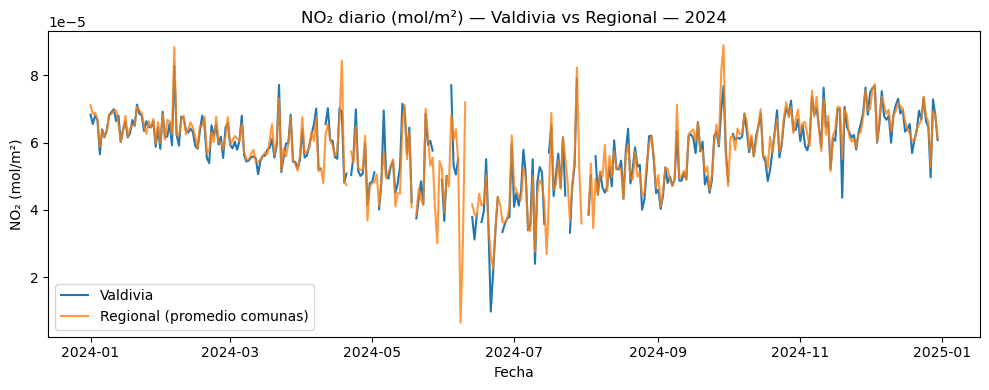

In [24]:
#plot para comparar
plt.figure(figsize=(10,4))
plt.plot(serie_comuna.index, serie_comuna, label=f"{comuna_sentinel}")
plt.plot(serie_regional.index, serie_regional, label="Regional (promedio comunas)", alpha=0.8)
plt.title(f"NO₂ diario (mol/m²) — {comuna_sentinel} vs Regional — 2024")
plt.xlabel("Fecha"); plt.ylabel("NO₂ (mol/m²)")
plt.legend(); plt.tight_layout()
plt.show()

Parte 4

Creamos panel diario (2024) que combine ERA5 y S5P

In [29]:
PROCESSED = Path("..\Data\processed")
##carga de Era 5 y se filtra por año 2024

def load_era5_var(nc_path, var_name):
    ds = xr.open_dataset(nc_path)
    var = list(ds.data_vars)[0]
    da = ds[var]
    df = da.to_dataframe().reset_index()

    df["fecha"] = pd.to_datetime(df["time"]).dt.normalize()
    df = df[df["fecha"].dt.year == 2024]

    df = (
        df.groupby("fecha")[var]
          .mean()
          .reset_index()
          .rename(columns={"fecha": "Fecha", var: var_name})
    )
    return df

t2m = load_era5_var(PROCESSED / "2t.nc", "Temp_K")
d2m = load_era5_var(PROCESSED / "2d.nc", "Dew_K")
rh = load_era5_var(PROCESSED / "rh_pct_daily.nc", "RH_pct")
ws = load_era5_var(PROCESSED / "wind_speed_daily.nc", "WindSpeed_m_s")

## Kelvin a celsius 
t2m["Temp_C"] = t2m["Temp_K"] - 273.15
d2m["DewPoint_C"] = d2m["Dew_K"] - 273.15

era5_all = (
    t2m[["Fecha", "Temp_C"]]
    .merge(d2m[["Fecha", "DewPoint_C"]], on="Fecha")
    .merge(rh[["Fecha", "RH_pct"]], on="Fecha")
    .merge(ws[["Fecha", "WindSpeed_m_s"]], on="Fecha")
)
era5_all["source"] = "ERA5"
era5_all ["qa_flag"] = 1

print ("ERA5 diario listo: ", era5_all.shape)


ERA5 diario listo:  (366, 7)


In [32]:
s5p = pd.read_csv(PROCESSED / "s5p_no2_stats_mensual_por_comuna.csv")

s5p["year"] = s5p["year"].astype(int)
s5p["month"] = s5p["month"].astype(int)
s5p["Fecha"] = pd.to_datetime(
    s5p["year"].astype(str) + "-" + s5p["month"].astype(str) + "-15"
)

#columnas clave
s5p = s5p[["Comuna", "Fecha", "NO2_mean"]]
s5p["source"] = "S5P_NO2"
s5p["qa_flag"] = 1

print("✅ S5P mensual listo:", s5p.shape)

✅ S5P mensual listo: (144, 5)


In [43]:
s5p["Fecha"] = pd.to_datetime(s5p["Fecha"]).dt.normalize()
#agregamos variables de era5 a cada columna 

#se crea la columna "year"
panel["year"] = panel["Fecha"].dt.year

#guardamos en formato parquet con particion por año

output_path = PROCESSED / "panel_integrado.parquet"
panel.to_parquet(output_path, partition_cols=["year"])

print (f"Panel final guardado")
display (panel.head(5))

panel["Fecha"].nunique()  #si da 12 hay consistencia ya que es uno por mes (s5p esta mensual)

         


Panel final guardado


,Comuna,Fecha,NO2_mean,source_s5p,qa_flag_s5p,Temp_C,DewPoint_C,RH_pct,WindSpeed_m_s,source_era5,qa_flag_era5,year
0,Corral,2024-01-15,0.000065,S5P_NO2,1,12.859741,11.250397,89.987434,2.835044,ERA5,1,2024
1,Corral,2024-02-15,0.000062,S5P_NO2,1,13.279327,10.968689,86.408142,1.138533,ERA5,1,2024
2,Corral,2024-03-15,0.000058,S5P_NO2,1,9.148041,7.367920,88.847565,1.287611,ERA5,1,2024
3,Corral,2024-04-15,0.000057,S5P_NO2,1,9.516876,8.984985,96.555794,2.840068,ERA5,1,2024
4,Corral,2024-05-15,0.000048,S5P_NO2,1,1.579498,-0.523987,86.413963,2.757514,ERA5,1,2024


12

Parte 5

Carga de datos

In [65]:
FIGS = Path("../Figs")
FIGS.mkdir(parents=True, exist_ok=True)

panel = pd.read_parquet("../Data/processed/panel_integrado.parquet")
panel = panel[panel["Fecha"].dt.year == 2024].copy()

RAW_S5P = Path("../Data/raw/s5p/SO2_NO2_O3_Diario_Comunas_Region_de_Los_Rios.csv")

VAR_NO2 = "NO2_mean" #de s5p
VAR_RH  = "RH_pct"  # de era5
VAR_CLASS = "class_no2"

Construir geometría de comunas desde la columna .geo del CSV

In [54]:
q5, q95 = np.nanquantile(panel[VAR_NO2], [0.05, 0.95])

n_bins = 6
edges = np.linspace(q5, q95, n_bins + 1)
edges[0]  = -np.inf
edges[-1] =  np.inf

labels = [f"[{edges[i]:.2e}, {edges[i+1]:.2e})" for i in range(n_bins)]
labels[0]  = f"< {q5:.2e}"
labels[-1] = f"> {q95:.2e}"

panel["class_no2"] = pd.cut(panel[VAR_NO2], bins=edges, labels=labels, include_lowest=True)
panel["month"] = panel["Fecha"].dt.month

print("q5:", q5, "q95:", q95)
panel[["Comuna", "Fecha", VAR_NO2, "class_no2"]].head()

q5: 4.393142797601866e-05 q95: 6.700398772357332e-05


,Comuna,Fecha,NO2_mean,class_no2
0,Corral,2024-01-15,0.000065,> 6.70e-05
1,Corral,2024-02-15,0.000062,"[5.93e-05, 6.32e-05)"
2,Corral,2024-03-15,0.000058,"[5.55e-05, 5.93e-05)"
3,Corral,2024-04-15,0.000057,"[5.55e-05, 5.93e-05)"
4,Corral,2024-05-15,0.000048,"[4.78e-05, 5.16e-05)"


In [55]:
def parse_geo(g):
    try:
        if pd.isna(g): 
            return None
        return shape(json.loads(g))  # GeoJSON -> shapely
    except Exception:
        return None

s5p = s5p.copy()
s5p["geometry"] = s5p[".geo"].apply(parse_geo)
s5p_geo = s5p[~s5p["geometry"].isna()].copy()

# GeoDataFrame en WGS84
gdf = gpd.GeoDataFrame(s5p_geo, geometry="geometry", crs="EPSG:4326")

# Una geometría por comuna (disolver por nombre)
gdf_comunas = (
    gdf[["Comuna", "Provincia", "Region", "geometry"]]
    .drop_duplicates(subset=["Comuna", "geometry"])
    .dissolve(by="Comuna", as_index=False, aggfunc="first")
)

gdf_comunas.head()

,Comuna,geometry,Provincia,Region


In [70]:
VAR_NO2 = "NO2_mean"

# comprobamos que existe
if VAR_NO2 not in panel.columns:
    raise ValueError(f"No existe la columna {VAR_NO2} en el panel")

# calculamos percentiles q5 y q95
q5, q95 = np.nanpercentile(panel[VAR_NO2], [5, 95])

# definimos los cortes (breaks) y etiquetas
n_bins = 6
edges = np.linspace(q5, q95, n_bins + 1)
edges[0] = -np.inf
edges[-1] = np.inf

labels = [f"[{edges[i]:.2e}, {edges[i+1]:.2e})" for i in range(n_bins)]
labels[0] = f"< {q5:.2e}"
labels[-1] = f"> {q95:.2e}"

# aplicamos la clasificación
panel["class_no2"] = pd.cut(
    panel[VAR_NO2],
    bins=edges,
    labels=labels,
    include_lowest=True
)

print("✅ Columna 'class_no2' creada correctamente.")
print("Percentiles:", q5, q95)
print(panel[["Comuna", "Fecha", VAR_NO2, "class_no2"]].head())

✅ Columna 'class_no2' creada correctamente.
Percentiles: 4.393142797601866e-05 6.700398772357332e-05
   Comuna      Fecha  NO2_mean             class_no2
0  Corral 2024-01-15  0.000065            > 6.70e-05
1  Corral 2024-02-15  0.000062  [5.93e-05, 6.32e-05)
2  Corral 2024-03-15  0.000058  [5.55e-05, 5.93e-05)
3  Corral 2024-04-15  0.000057  [5.55e-05, 5.93e-05)
4  Corral 2024-05-15  0.000048  [4.78e-05, 5.16e-05)


In [71]:
# --- 5.4 Mapas mensuales (q5–q95 fijos) ---

# columnas que voy a necesitar
cols_panel = ["Comuna", "month", "class_no2", VAR_NO2, "Fecha"]

# por si acaso: casteamos el nombre de comuna a string y normalizamos
panel["Comuna"] = panel["Comuna"].astype(str).str.strip()
gdf_comunas["Comuna"] = gdf_comunas["Comuna"].astype(str).str.strip()

# helper para elegir la última fila por comuna de cada mes (si hubiese duplicados)
def _ultima_por_comuna(df_mes):
    return (
        df_mes.sort_values(["Comuna", "Fecha"])
              .drop_duplicates(subset=["Comuna"], keep="last")
    )

# función robusta para un mes
def plot_map_mes(mes: int):
    # 0) chequeos rápidos
    for c in cols_panel:
        if c not in panel.columns:
            raise ValueError(f"Falta columna en panel: {c}")
    if "geometry" not in gdf_comunas.columns:
        raise ValueError("gdf_comunas no tiene columna 'geometry'")

    # 1) subset del mes y 1 fila por comuna
    df_mes = panel.loc[panel["month"] == mes, cols_panel].copy()
    df_mes = _ultima_por_comuna(df_mes)

    # 2) unión a la geometría (quedan todas las comunas de Los Ríos)
    gplot = gdf_comunas.merge(df_mes, on="Comuna", how="left")

    # 3) si falta class_no2 (por ejemplo si recalculaste breaks), la creo con los edges/labels ya definidos
    if "class_no2" not in gplot.columns or gplot["class_no2"].isna().all():
        gplot["class_no2"] = pd.cut(
            gplot[VAR_NO2],
            bins=edges,
            labels=labels,
            include_lowest=True
        )

    # 4) plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    # cantidad de comunas con dato ese mes
    n_con_dato = gplot[VAR_NO2].notna().sum()
    print(f"Mes {mes:02d}: comunas con datos = {n_con_dato}/{len(gplot)}")

    # contorno base (todas las comunas)
    gdf_comunas.plot(ax=ax, color="none", edgecolor="lightgrey", linewidth=0.6)

    if n_con_dato > 0:
        # polígonos con dato
        gplot.plot(
            column="class_no2",
            ax=ax,
            legend=True,
            cmap="viridis",
            edgecolor="white",
            linewidth=0.5,
            missing_kwds={"color": "lightgrey", "label": "Sin dato"}
        )
    else:
        # sin datos: sólo contorno y texto
        ax.text(
            0.02, 0.02, "Sin datos este mes",
            transform=ax.transAxes, fontsize=12, color="0.4"
        )

    # título, aspecto y límites (evita el error "aspect must be finite")
    xmin, ymin, xmax, ymax = gdf_comunas.total_bounds
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal")
    ax.set_title(f"{VAR_NO2} — Mes {mes:02d} (breaks fijos q5–q95 2024)")
    ax.axis("off")

    # guardar
    out = FIGS / f"map_no2_2024_{mes:02d}.png"
    fig.tight_layout()
    fig.savefig(out, dpi=140)
    plt.close(fig)
# --- asegurar columna de mes en panel ---
if "month" not in panel.columns:
    if "Fecha" not in panel.columns:
        raise ValueError("Tu panel no tiene la columna 'Fecha'.")
    panel["Fecha"] = pd.to_datetime(panel["Fecha"])
    panel["month"] = panel["Fecha"].dt.month
    print("✅ Columna 'month' creada correctamente.")
else:
    print("✅ 'month' ya existía en el panel.")

# --- Generar los 12 mapas ---
for m in range(1, 13):
    plot_map_mes(m)


✅ 'month' ya existía en el panel.
Mes 01: comunas con datos = 12/12
Mes 02: comunas con datos = 12/12
Mes 03: comunas con datos = 12/12
Mes 04: comunas con datos = 12/12
Mes 05: comunas con datos = 12/12
Mes 06: comunas con datos = 12/12
Mes 07: comunas con datos = 12/12
Mes 08: comunas con datos = 12/12
Mes 09: comunas con datos = 12/12
Mes 10: comunas con datos = 12/12
Mes 11: comunas con datos = 12/12
Mes 12: comunas con datos = 12/12


Small multiples por provincia 

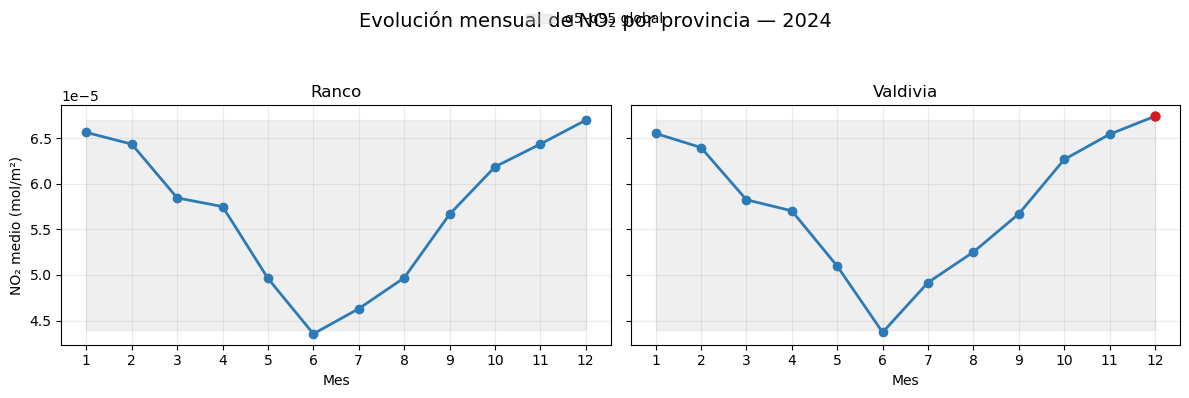

Figuras guardadas en:
 - ..\Figs\no2_smallmultiples_2024.png
 - ..\Figs\no2_smallmultiples_2024.svg


In [77]:
if "Provincia" not in panel.columns:
    panel = panel.merge(
        gdf_comunas[["Comuna", "Provincia"]],
        on="Comuna",
        how="left"
    )

# 2) Asegurar columna 'month' (1..12)
if "month" not in panel.columns:
    panel["month"] = panel["Fecha"].dt.month

# 3) Promedio mensual por provincia
prov_month = (
    panel.groupby(["Provincia", "month"], as_index=False)
         .agg(NO2_mean=("NO2_mean", "mean"))
)

# 4) Banda de referencia: q5–q95 global (sobre todos los registros 2024)
q5, q95 = panel["NO2_mean"].quantile([0.05, 0.95])
meses = np.arange(1, 13)

# 5) Provincias (orden alfabético para que sea reproducible)
provincias = sorted(prov_month["Provincia"].dropna().unique())
n = len(provincias)

fig, axes = plt.subplots(1, n, figsize=(6*n, 4), sharey=True)
if n == 1:  # cuando hay solo una provincia, axes no es array
    axes = [axes]

for ax, prov in zip(axes, provincias):
    df = prov_month[prov_month["Provincia"] == prov].sort_values("month")

    # banda q5–q95 global como referencia
    ax.fill_between(meses, q5, q95, color="lightgray", alpha=0.35, label="q5–q95 global")

    # línea mensual con marcadores
    ax.plot(df["month"], df["NO2_mean"], marker="o", lw=2, color="#2c7bb6")

    # resaltar meses por sobre q95
    extremos = df["NO2_mean"] > q95
    ax.scatter(df.loc[extremos, "month"], df.loc[extremos, "NO2_mean"],
               color="#d7191c", s=40, zorder=3, label="> q95" if extremos.any() else None)

    ax.set_title(prov)
    ax.set_xlabel("Mes")
    ax.set_xticks(meses)
    ax.grid(True, alpha=0.25)

axes[0].set_ylabel("NO₂ medio (mol/m²)")
fig.suptitle("Evolución mensual de NO₂ por provincia — 2024", fontsize=14)

# Evitar duplicados en la leyenda (si varias provincias tienen puntos >q95)
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper center", ncols=2, frameon=False)

plt.tight_layout(rect=(0, 0, 1, 0.92))

# 6) Guardar
out_png = FIGS / "no2_smallmultiples_2024.png"
out_svg = FIGS / "no2_smallmultiples_2024.svg"
fig.savefig(out_png, dpi=200)
fig.savefig(out_svg)
plt.show()

print(f"Figuras guardadas en:\n - {out_png}\n - {out_svg}")